In [2]:
#to create the method
import torch
import torch.nn as nn
import torch.nn.functional as F

#for this notebook and probably main file
import matplotlib.pyplot as plt
import numpy as np
from utils.data import get_dataloader

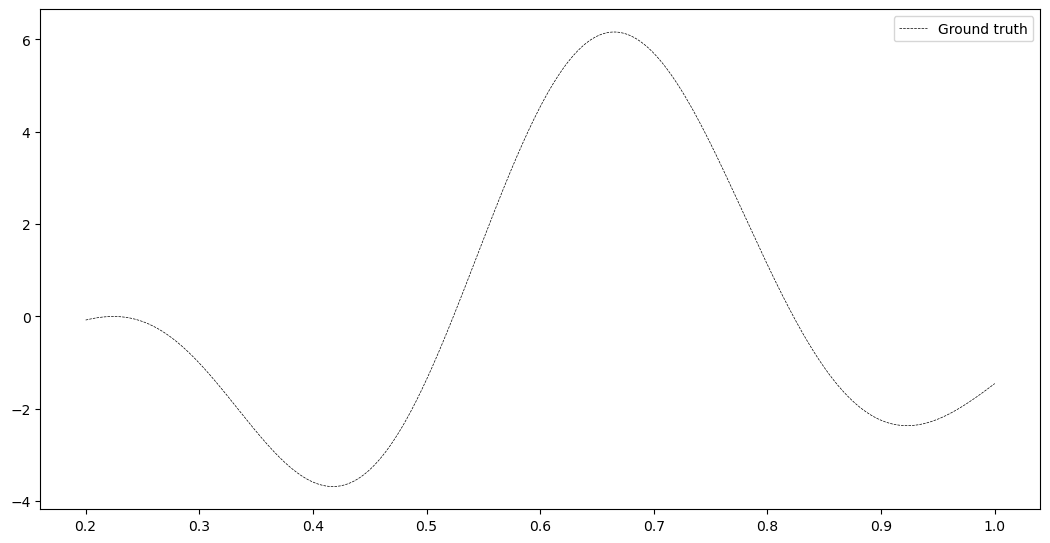

In [3]:
def function(x):
    return -(torch.sin(x*7)+torch.cos(14*x))*(x**2)*torch.exp(-4*x)*100

#range for sampling
xmin=0.2
xmax=1.00
points_plot=1000                              #resolution to plot the ground truth 
x_plot=torch.linspace(xmin, xmax, points_plot) 
y_plot=function(x_plot)

fig = plt.figure(figsize=(10,5))
ax=fig.add_axes([0,0,1,1])
ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
# ax.scatter(t2,PC,label=r"Predictions",color='g',s=10)
# plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)
plt.legend(prop={'size': 10})

In [4]:
training_samples = 1000                   
x_data=np.random.uniform(xmin, xmax, training_samples)
x_data = torch.from_numpy(x_data.astype(np.float32)).view(-1,1)
y_data=function(x_data)
train_loader, _ = get_dataloader(x_data, y_data, 1, 1, train_test_split=1.0, batch_size=32)

x_batch,y_batch = next(iter(train_loader))  #to fix the x value in the reconstruction training
x_batch.shape, y_batch.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [5]:
class BNN_BPP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BNN_BPP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the Bayesian neural network architecture based any number of hidden_sizes
        self.fc_mu = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.fc_log_var = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        for i in range(len(hidden_sizes) - 1):   #adding  layers for mu and log_var
            self.fc_mu.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.fc_log_var.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.fc_mu.append(nn.Linear(hidden_sizes[-1], output_size))
        self.fc_log_var.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    # Define loss function (variational lower bound)
    def variational_loss(self, output_mu, output_log_var, target):
        recon_loss = F.mse_loss(output_mu, target, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + output_log_var - output_mu.pow(2) - output_log_var.exp())
        return recon_loss + kl_divergence
    
    def train(self, train_loader,num_epochs=10, lr=1e-3, verbose=0):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for inputs, targets in train_loader:       
                optimizer.zero_grad()
                output_mu, output_log_var = self(inputs)
                loss = self.variational_loss(output_mu, output_log_var, targets)
                loss.backward()
                optimizer.step()

            if not verbose == 0: 
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        
    def forward(self, x):
        # Encoder
        hidden_mu = F.relu(self.fc_mu[0](x))
        hidden_log_var = F.relu(self.fc_log_var[0](x))
        
        # Reparameterization trick
        hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
        
        # Decoder
        for i in range(1, len(self.fc_mu)-1):   #predictions with Reparameterization over all layers but last one (modified)
            print(hidden_rep.shape, i)
            hidden_mu = F.relu(self.fc_mu[i](hidden_rep))
            hidden_log_var = F.relu(self.fc_log_var[i](hidden_rep))
            hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
            print(hidden_rep.shape, i)
        
        output_mu = self.fc_mu[-1](hidden_rep)
        output_log_var = self.fc_log_var[-1](hidden_rep)
        
        return output_mu, output_log_var

In [6]:
# Example usage
input_size = 1
hidden_sizes = [20]
output_size = 1

model = BNN_BPP(input_size, hidden_sizes, output_size)

In [7]:
model.train(train_loader, num_epochs=1000, verbose=1)

Epoch [1/1000], Loss: 29.635509490966797
Epoch [2/1000], Loss: 96.70702362060547
Epoch [3/1000], Loss: 163.40081787109375
Epoch [4/1000], Loss: 97.720947265625
Epoch [5/1000], Loss: 75.88780975341797
Epoch [6/1000], Loss: 89.70745086669922
Epoch [7/1000], Loss: 116.84963989257812
Epoch [8/1000], Loss: 53.07624053955078
Epoch [9/1000], Loss: 66.01078796386719
Epoch [10/1000], Loss: 90.84646606445312
Epoch [11/1000], Loss: 99.84024810791016
Epoch [12/1000], Loss: 60.124290466308594
Epoch [13/1000], Loss: 57.528778076171875
Epoch [14/1000], Loss: 53.849151611328125
Epoch [15/1000], Loss: 80.66995239257812
Epoch [16/1000], Loss: 176.98387145996094
Epoch [17/1000], Loss: 68.27213287353516
Epoch [18/1000], Loss: 23.853862762451172
Epoch [19/1000], Loss: 101.01390075683594
Epoch [20/1000], Loss: 33.29920959472656
Epoch [21/1000], Loss: 106.44174194335938
Epoch [22/1000], Loss: 122.32455444335938
Epoch [23/1000], Loss: 63.4491081237793
Epoch [24/1000], Loss: 118.66905212402344
Epoch [25/1000],

In [ ]:
#n_sim forward passes for uq
num_sim = 100
mean = torch.empty(len(x_plot), num_sim)
std = torch.empty(len(x_plot), num_sim)

for sim in range(num_sim):
   mean[:, sim], std[:, sim] = model(x_plot)

In [ ]:
# #range for sampling
# points_plot=1000                              #resolution of the ground truth 
# x_plot=np.linspace(xmin,xmax,points_plot) 
# y_plot=function(x_plot)

# x_train_net = torch.from_numpy(x_plot.astype(np.float32)).view(-1,1)
# y_bnn = net.predict(x_train_net).cpu().detach().numpy()
# y_bnn_pred = net.sample_predict(x_train_net, Nsamples=10).cpu().detach().numpy()
# y_bnn_mean = np.mean(y_bnn_pred, axis=0)
# y_bnn_std = np.std(y_bnn_pred, axis=0)

# fig = plt.figure(figsize=(10,5))
# ax=fig.add_axes([0,0,1,1])
# ax.plot(x_plot, y_plot,label=r"Ground truth",linestyle='dashed',linewidth=0.5,color='k')
# ax.plot(x_plot, y_bnn,label=r"BNN",linestyle='dashed',linewidth=1,color='b')
# ax.plot(x_plot, y_bnn_mean,label=r"BNN_mean",linestyle='dashed',linewidth=0.5,color='r')
# ax.plot(x_plot, y_bnn_mean+y_bnn_std,label=r"BNN_std",linestyle='dashed',linewidth=0.5,color='g')
# ax.plot(x_plot, y_bnn_mean-y_bnn_std,label=r"BNN_std",linestyle='dashed',linewidth=0.5,color='g')
# # ax.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
# # ax.scatter(t2,PC,label=r"Predictions",color='g',s=10)
# plt.scatter(xn, M, label="Observations",marker="x",color='r',s=200)

In [ ]:
## CHAT GPT implementation

import torch
import torch.nn as nn
import torch.nn.functional as F

class BayesianNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(BayesianNN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        
        # Define the Bayesian neural network architecture dynamically based on hidden_sizes
        self.fc_mu = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        self.fc_log_var = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        for i in range(len(hidden_sizes) - 1):
            self.fc_mu.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            self.fc_log_var.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.fc_mu.append(nn.Linear(hidden_sizes[-1], output_size))
        self.fc_log_var.append(nn.Linear(hidden_sizes[-1], output_size))
        
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x):
        # Encoder
        hidden_mu = F.relu(self.fc_mu[0](x))
        hidden_log_var = F.relu(self.fc_log_var[0](x))
        
        # Reparameterization trick
        hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
        
        # Decoder
        for i in range(1, len(self.fc_mu)):
            hidden_mu = F.relu(self.fc_mu[i](hidden_rep))
            hidden_log_var = F.relu(self.fc_log_var[i](hidden_rep))
            hidden_rep = self.reparameterize(hidden_mu, hidden_log_var)
        
        output_mu = self.fc_mu[-1](hidden_rep)
        output_log_var = self.fc_log_var[-1](hidden_rep)
        
        return output_mu, output_log_var

# Example usage
input_size = 10
hidden_sizes = [20, 15, 10]  # You can modify this list to change the number of hidden layers and their sizes
output_size = 1

model = BayesianNN(input_size, hidden_sizes, output_size)

# Rest of the code (loss function, training loop) remains unchanged...

# Define loss function (variational lower bound for regression)
def variational_loss(output_mu, output_log_var, target):
    recon_loss = F.mse_loss(output_mu, target)
    kl_divergence = -0.5 * torch.sum(1 + output_log_var - output_mu.pow(2) - output_log_var.exp())
    return recon_loss + kl_divergence

# Training loop (assuming data and targets are available)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Assuming `data` and `targets` are your input and output training data
num_epochs = 10

for epoch in range(num_epochs):
    optimizer.zero_grad()
    output_mu, output_log_var = model(data)
    loss = variational_loss(output_mu, output_log_var, targets)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

